<a href="https://colab.research.google.com/github/FarahBouattour/knowWhatToEat/blob/main/mae_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###univariate time series LSTM first try

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
print(tf.__version__)

2.5.0


In [38]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

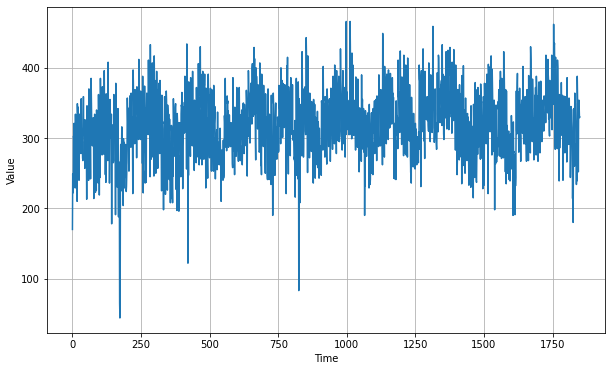

In [39]:
#df = pd.read_csv('reffined_data.csv')
df = pd.read_csv('data_pca_dt_covid_fi.csv')
df = df.iloc[:1850]

series = np.array(df['flux_journalier'])
#time_step = np.array(df['Date'])
time = np.array([i for i in range(len(df))]) 
plt.figure(figsize=(10, 6))
plot_series(time, series)

Clean data by removing the three pics from the series

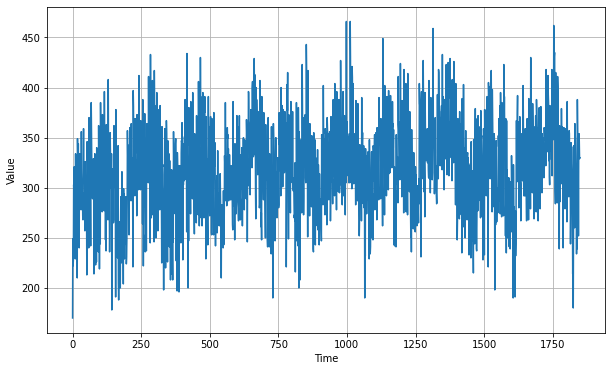

In [40]:
denoised_series = [i if i>150 else 200 for i in list(series)]

plt.figure(figsize=(10, 6))
plot_series(time, denoised_series)

In [41]:
denoised_series = np.array(denoised_series)

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(denoised_series.reshape(-1,1))
series = scaler.transform(denoised_series.reshape(-1,1))


split_time = 1250  #600
time_train = time[:split_time]
x_train = series[:split_time] 
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 7 # 30 slices worth of data, so we're splitting the x_train 30 times !!!
batch_size = 30

print('total',series.shape)
print('train',x_train.shape)
print('test', x_valid.shape)

total (1850, 1)
train (1250, 1)
test (600, 1)


In [43]:
# Window dataset, we're going to use it on x_train
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # This is required since we have specified a specific input function in the model
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [44]:
# We take the DNN model, and we try to apply it to our series use the window technique
# So after training it will help us forecast
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # No map or shuffle, this was done in the windowed_dataset()
    forecast = model.predict(ds)
    return forecast

In [72]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

batch_size = 32 #128
shuffle_buffer = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer) # We take a window of x_train
print("train_set= ",train_set)
print("\n x_train.shape= ",x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), # We have specified the input shape here so we need to change the windowed_dataset()
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(512, return_sequences=True),
  #tf.keras.layers.SimpleRNN(32, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

# The whole purpose of this cell is to know which learning rate to use using the lr_schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])


train_set=  <PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>

 x_train.shape=  (1250, 1)
Epoch 1/20
39/39 [==============================] - 3s 14ms/step - loss: 0.1359 - mae: 0.3866
Epoch 2/20
39/39 [==============================] - 1s 14ms/step - loss: 0.0269 - mae: 0.1736
Epoch 3/20
39/39 [==============================] - 1s 14ms/step - loss: 0.0202 - mae: 0.1533
Epoch 4/20
39/39 [==============================] - 1s 14ms/step - loss: 0.0161 - mae: 0.1391
Epoch 5/20
39/39 [==============================] - 1s 14ms/step - loss: 0.0141 - mae: 0.1317
Epoch 6/20
39/39 [==============================] - 1s 15ms/step - loss: 0.0133 - mae: 0.1278
Epoch 7/20
39/39 [==============================] - 1s 14ms/step - loss: 0.0128 - mae: 0.1261
Epoch 8/20
39/39 [==============================] - 1s 14ms/step - loss: 0.0125 - mae: 0.1250
Epoch 9/20
39/39 [==============================] - 1s 14ms/step - loss: 0.0121 - mae: 0.1222
Epoch 10/20
39

In [73]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print("1",scaler.inverse_transform(np.squeeze(rnn_forecast)))
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1,0] 
print("\n2",np.array(rnn_forecast.shape))

1 [[295.4644  292.58768 278.24124 ... 260.29895 250.32228 255.11325]
 [301.31747 294.95563 288.08395 ... 279.07938 273.77197 289.1938 ]
 [299.4009  294.34625 295.39578 ... 281.78897 286.63733 292.2035 ]
 ...
 [316.0342  313.86746 316.87723 ... 312.98996 316.5378  329.175  ]
 [311.72565 310.46967 305.37357 ... 309.65283 314.315   323.37125]
 [310.42288 303.26135 303.2747  ... 309.90088 310.8634  318.51483]]
(1844, 7, 1)

2 [600]


In [74]:
#results['Date'] = df['Date']
pred = pd.DataFrame(scaler.inverse_transform(rnn_forecast.reshape(-1,1)))
real = pd.DataFrame(scaler.inverse_transform(x_valid))

results = pd.concat([real,pred, real-pred], axis = 1)
#results = results.rename(columns={0: ('flux_réel', 'prediction')})
print('Max = ', max(results.iloc[:,2]))
print([int(i) for i in list(results.iloc[:,2])])

Max =  114.90515136718744
[7, -16, 14, -22, -9, -47, -25, -5, -4, -17, -21, -37, 7, -16, 102, 81, 72, 57, 33, -12, -96, 20, 31, -12, -37, 8, -3, 19, 59, 33, 17, -40, -35, 7, -70, 26, 8, 6, 46, 0, 13, 29, -41, 20, -3, 8, 15, -11, -13, 81, 31, -22, -13, 29, -35, 7, 16, 23, -7, 19, 2, -8, -17, 20, 114, 25, 5, -20, 11, -37, -80, -22, 26, -35, -14, -19, -15, -21, -38, -2, 82, 24, 8, -3, 111, 107, 35, -33, -26, 5, -12, -31, -30, 26, 36, 35, 2, -38, 63, -45, 8, -3, 2, -52, -62, 29, 14, -22, -35, 14, 20, 6, 49, 6, -31, -38, 10, 26, 0, 41, -24, 11, -28, 0, 17, -17, 53, 55, 39, 52, -4, -32, -27, -87, 33, -2, -18, -26, -17, -10, 88, -66, 23, 20, -5, -33, -89, 46, 6, -87, -53, -49, -73, -20, 51, 42, 45, 30, 20, -35, -28, 34, -9, 12, 35, 22, -5, -26, 17, -82, 74, -8, 32, -20, -42, 86, 28, -3, 25, -19, 8, -50, -20, 42, 8, 18, -11, -4, -33, 17, 10, -23, 17, -41, -41, -69, 9, -48, -6, 5, 27, -32, -68, 33, -3, -23, 22, -46, -47, -53, -69, -87, 57, 27, 21, -33, -52, 39, 76, -12, 5, -44, -74, -62, -39, 5

(600,)
(600, 1)
(600,)


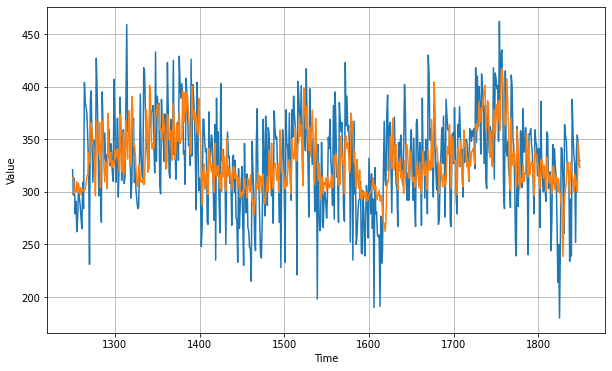

In [75]:
print(time_valid.shape)      
print(x_valid.shape)         
print(rnn_forecast.shape)    
plt.figure(figsize=(10, 6))
title = str("Forecasting with LSTM")
plot_series(time_valid, scaler.inverse_transform(x_valid)) # 2-D
plot_series(time_valid, scaler.inverse_transform(rnn_forecast.reshape(-1,1))) # we only took the last part of the rnn_forecast


In [76]:
tf.keras.metrics.mean_absolute_error(np.squeeze(x_valid), 
                                                np.squeeze(rnn_forecast)).numpy()

0.10553887

In [77]:
tf.keras.metrics.mean_absolute_error(np.squeeze(scaler.inverse_transform(x_valid)), 
                                     np.squeeze(scaler.inverse_transform(rnn_forecast.reshape(-1,1)))).numpy()

31.239502

In [78]:
tf.keras.metrics.mean_absolute_percentage_error(np.squeeze(x_valid), 
                                                np.squeeze(rnn_forecast)).numpy()

27.06792